# Apresentação ✒️

Notebook destinado ao estudo das Redes Neurais Recorrentes (RNN's). A sua principal diferença quando comparada com outras arquiteturas, como multi layer perceptrons ou redes neurais convulucionais, é que pelo atributo da recorrência passam a reter informação do resultado anterior, sendo essa retenção cumulativa ao longo do processo iterativo.

Por meio disso, cria um tipo de memória que consegue compreender as relações de dependência dos termos a ela passados ao longo do tempo, sendo por conta disso implementada para a resolução de problemas que a sua evolução ou ordenação apresenta relações de dependência com o tempo.



## Arquitetura das RNN's

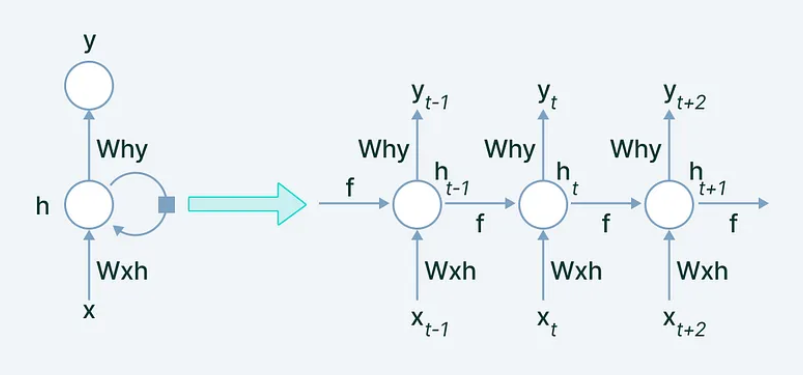

A imagem acima busca representar como se dá o fluxo do aprendizado de uma RNN. A letra V indica a passagem de informação ao longo da rede, os termos nos neurônios indicam o instante no tempo de cada qual e os termos abaixo desses indica a ordem de entrada. Acima dos neurônios recorrentes estão os perceptrons, responsáveis pela realização da inferência.

>

A recorrência da rede é representada pela seta curva do primeiro neurônio recorrente representado. Ela ilustra o funcionamento desse tipo de arquitetura que retorna a saída do neurônio próprio para si, criando uma relação de conhecimento prévio para novos dados de entrada.

>

Por meio dele, como era antes com as redes convulucionais ou MLP's, não há apenas os dados de entrada nos neurônios, mas também a informação anteriormente gerada, sendo esse o elemento construtor de um tipo de memória para essas redes neurais.

>

O fluxo de aprendizado dessas redes ocorre da seguinte forma : em cada passo de tempo, a entrada é processada por uma célula RNN, que combina essa entrada com o estado oculto (memória) do passo de tempo anterior para produzir um novo estado oculto, o qual é usado para fazer previsões. Durante o treinamento, a função de perda é calculada com base nas previsões feitas pela rede e os valores reais. Em seguida, os gradientes da função de perda são calculados e usados para atualizar os parâmetros da rede (pesos e vieses) por meio do algoritmo de backpropagation through time (BPTT). No próximo passo de tempo, a célula RNN utilizará a nova entrada junto com o estado oculto atualizado, permitindo que a rede capture dependências temporais ao longo da sequência.

## Motivação

Ainda que o estudo das RNN's possa parecer supérfulo perante ao advento da arquitetura dos transformers, que consegue desempenhar de uma forma mais efetiva sobre os principais campos de estudo nos quais a presente arquitetura se debruçava, essa ainda pode encontrar implementação em outros âmbitos, como séries temporais, demonstrando a importância da sua compreensão.

>

Além disso, acredito ser importante para estudantes de machine learning terem compreensão das principais arquiteturas existentes de deeplearning, fomentando um conhecimento prático e amplo sobre a área de estudo.

>

Como caso de uso, para ilustrar o funcionamento da RNN, irei criar um projeto cujo objetivo é informar um sobrenome e pedir para que a rede consiga inferir o seu local de origem. Para isso, ela deverá compreender as relações de dependência da palavra com cada tipo de idioma presente, para que consiga, assim, realizar a inferência sobre o local de origem do nome fornecido.  


## Biblioteca 📚

In [39]:
import os
import torch
import string
import unicodedata
import numpy as np

import seaborn as sns
sns.set_style('darkgrid')

import matplotlib.pyplot as plt
%matplotlib inline

from torch import nn


## Importando os dados 💾

In [3]:
# comente as duas linhas seguintes caso rode mais de uma vez
!wget https://download.pytorch.org/tutorial/data.zip #
!unzip data.zip #
############################################################

--2024-07-26 18:34:44--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.164.154.30, 18.164.154.37, 18.164.154.123, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.164.154.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  --.-KB/s    in 0.1s    

2024-07-26 18:34:44 (24.5 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/I

## Verificando o tipo de processador utilizado



In [4]:
torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device(type='cuda')

## Lendo o conjunto de dados

In [5]:
def le_arquivos(path):

  nomes = open(path).read().split('\n')
  nomes = [unicodedata.normalize('NFKD', nome).encode('ascii', 'ignore') for nome in nomes]

  categoria = path.split('/')[-1].split('.')[0]
  categorias = np.repeat(categoria, len(nomes))

  return nomes, categorias

In [6]:
root = 'data/names/'

arquivos = sorted(os.listdir(root))

dados, rotulos = [], []

for arquivo in arquivos:
  nomes, categorias = le_arquivos(os.path.join(root, arquivo))

  dados.append(nomes)
  rotulos.append(categorias)

In [7]:
# Visualizando os 5 primeiros
# nomes japoneses.

dados[10][:5]

[b'Abe', b'Abukara', b'Adachi', b'Aida', b'Aihara']

## Convertendo o texto em Tensor

### Convertendo os rótulos (idiomas)

In [8]:
# Extraindo o nome das nacionalidades presentes em arquivos.

categorias = [arquivo.split('.')[0] for arquivo in arquivos]

# Visualizando as 5 primeiras categorias.

categorias[:5]

['Arabic', 'Chinese', 'Czech', 'Dutch', 'English']

In [9]:
# Trecho que extrai a posição do idioma na lista do arquivo.

posicao = categorias.index('Chinese')
posicao

1

In [26]:
# Função que realiza a extração da posição do idioma na lista
# e o transforma num tensor.

def labl2tensor(str):

  posicao = categorias.index(str)

  return torch.LongTensor([posicao])

In [27]:
# Visualizando o resultado da função :

rotulos[5][10], labl2tensor(rotulos[5][10])

('French', tensor([5]))

### Convertendo os nomes presentes nos idiomas

In [12]:
"""
Criando um dicionário a partir do qual a representação em One-hot terá que codificar.
Nesse tipo de representação, as palavras não são transformadas em sua forma vetorial,
mas cada letra ou palavra é simbolizada com um número, 0 ou 1, os quais indicam
a sua presença ou ausência no texto informado, formando assim uma matriz esparsa.

Não obstante, o presente dicionário irá codificar todas as letras do alfabeto
comum, além da presença do espaço, das apostrofes e dos traços, presentes em alguns
sobrenomes e nomes das pessoas. Ex : Sant'Ana, Da Silva, Chun-han e etc.
"""

dicionario = string.ascii_letters + " ' -"

# Visualizando o dicionário :
dicionario

"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ ' -"

In [13]:
def name2tensor(name):

  name_tensor = torch.zeros(len(name), len(dicionario))

  for i, char in enumerate(name.decode('utf-8')):
    name_tensor[i][dicionario.find(char)] = 1

  return name_tensor

In [14]:
# Visualizando a transformação :

dados[5][10], name2tensor(dados[5][10])

(b'Baudin',
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0.,

## Balanceamento

Para a etapa de treinamento de um modelo de deeplearning é importante que os dados estejam balanceados, para que não haja viés no aprendizado, prejudicando a inferência do modelo para dados que estejam em menor proporção.

Dessa forma, a célula seguinte realiza uma iteração nos dados, informando a proporção de dados (nomes) presentes em cada idioma. Nota-se que os dados estão balanceados, tendo em vista que há idiomas com apenas 74 amostras, enquanto outras com 2001, revelando a necessidade de se realizar o balanceamento.

A estratégia de balanceamento é selecionar uma amostra de no máximo 50 dados por iteração, que será realizado por uma função que será requisitada a cada ciclo iterativo durante a etapa de treinamento da RNN.


In [15]:
for i in range(len(categorias)):

  idioma = rotulos[i][i]
  qt_dados = len(dados[i])

  print(f'{idioma} : {qt_dados}')

Arabic : 2001
Chinese : 269
Czech : 520
Dutch : 298
English : 3669
French : 278
German : 725
Greek : 204
Irish : 233
Italian : 710
Japanese : 992
Korean : 95
Polish : 140
Portuguese : 75
Russian : 9409
Scottish : 101
Spanish : 299
Vietnamese : 74


In [28]:
def realiza_amostra(num_amostra):

  dados_amostra, rotulos_amostra = [], []

  for categoria in categorias:

    num_nomes = len(dados[categorias.index(categoria)])

    indices = np.random.choice(range(num_nomes), size = num_amostra)

    dados_amostra.extend([dado for indice, dado in enumerate(dados[categorias.index(categoria)]) if indice in indices])
    rotulos_amostra.extend([rotulo for indice, rotulo in enumerate(rotulos[categorias.index(categoria)]) if indice in indices])

  dados_tensor = [name2tensor(nome) for nome in dados_amostra]
  rotulos_tensor = [labl2tensor(categoria) for categoria in rotulos_amostra]

  return dados_tensor, rotulos_tensor


## Criando a RNN

In [17]:
# Dicionário que armazena o learning_rare e
# weight_decay, que são hiperparâmetros que influem
# no processo de otimização.

args = {'lr' : 5e-5,
        'weight_decay' : 1e-7,
        'device' : torch.device('cuda' if torch.cuda.is_available() else 'cpu')}

In [18]:
class RNN(nn.Module):

  def __init__(self, input_size, hidden_size, output_size):
    super(RNN, self).__init__()

    # Definindo os atributos da classe

    self.hidden_size = hidden_size
    self.input_size = input_size
    self.output_size = output_size


    # Criando a arquitetura da rede :

    # Cria os neurônios recorrentes, que recebem os dados de entrada
    # e os envia à camada escondida, para o processamento.

    self.rnn = nn.RNNCell(input_size, hidden_size)

    # Recebe da camada escondida os dados e os envia à camada de saída.

    self.output = nn.Linear(hidden_size, output_size)

    # Função de ativação presente nos neurônios de saída, responsável
    # por gerar uma distribuição de probabilidade para cada categoria.

    self.activation = nn.LogSoftmax()

  # Função que realiza a propagação do neurônio.

  def forward(self, nome):

    # Inicializa a o estado interno (memória)
    # do neurônio recorrente, junto do dispositivo de uso.

    h = torch.zeros(1, self.hidden_size).to(args['device'])

    # Processo de iteração que irá atualizar a cada passo
    # o estado interno (memória) do neurônio recorrente.

    for letra in nome:

      letra = letra.unsqueeze(0)
      h = self.rnn(letra, h)

    output = self.activation(self.output(h))

    return output

In [19]:
input_size = len(dicionario)
hidden_size = 256
output_size = len(categorias)

modelo = RNN(input_size, hidden_size, output_size)
modelo.to(args['device'])

RNN(
  (rnn): RNNCell(56, 256)
  (output): Linear(in_features=256, out_features=18, bias=True)
  (activation): LogSoftmax(dim=None)
)

## Definindo a Loss e Otimizador

In [20]:
"""
Como se trata de um problema de classificação no qual a paritr do
nome dado deseja-se saber a qual origem ela pertence, ou seja, para
que consiga-se depreender a origem deve-se realizar uma classificar
do nome em relação a todos os idiomas presentes e escolher aquele
que oferecer a melhor pontuação, escolherei como a função de perda
a NLLoss.

A sua característica é similar ao da entropia cruzada, mas como
ao final passamos como função de ativação LogSoftmax(), que por padrão
é interno da entropia cruzada, eu não poderia utilizar essa função de
ativação no neurônio de saída, pois (responder depois)
"""

criterio = nn.NLLLoss().to(args['device'])

optimizer = torch.optim.Adam(modelo.parameters(),
                             lr = args['lr'],
                             weight_decay = args['weight_decay'])

## Treinamento

In [36]:
def forward(X, y, etapa):

  if etapa =='Treino':
    modelo.train()
  else:
    modelo.eval()

  acuracia = 0.
  loss_epoca = []
  for k, (dado, rotulo) in enumerate(zip(X, y)):

    # Armazenando tanto o dado (o nome) quanto o rótulo
    # (os idiomas) na GPU.
    dado = dado.to(args['device'])
    rotulo = rotulo.to(args['device'])

    # Trecho que realiza a propagação do modelo.
    output = modelo(dado)

    # Trecho que calcula a loss.
    loss = criterio(output, rotulo)

    # Trecho que adiciona a loss na lista da loss por época,
    # desaclopa os tensores da GPU, enviando-os à CPU, os quais
    # são posteriormente transformados em array numpy, permitindo
    # a realização de cálculos, como o da acurácia do modelo criado.

    loss_epoca.append(loss.detach().cpu().numpy())

    # Trecho que realiza a predição do modelo, retornando o valor
    # máximo ao longo da dimensão. A saída do método especificado
    # retorna tanto a probabilidade quanto o seu índice. Como estou
    # apenas interessado no índice, descarto a probabilidade, sedo
    # representado pelo underline ( _ ).

    _, pred = torch.max(output, axis = -1)

    # Calcula-se a acurácia, incrementando-a por 1 à medida
    # que o modelo acerta em sua inferência.

    acuracia += 1 if pred[0].item() == rotulo[0].item() else 0

    if etapa == 'Treino':

      # Zerando os gradientes a cada etapa de otimização.
      # Por padrão, os gradientes não são zeradas a cada processo
      # de atualização dos parâmetros a partir da etapa de backward.

      optimizer.zero_grad()

      # Aplicando o cálculo do gradiente com base na função de perda
      # na rede neural recorrente, para que atualize seus parâmetros
      # e, com isso, melhorando o seu aprendizado ao longo do processo
      # iterativo.

      loss.backward()

      # Atualizando os parâmetros da rede neural, após o cálculo do gradiente,
      # junto do learning rate. Aqui, é como se o modelo desse um passo adiante
      # do mínimo global, reduzindo a sua perda e, portanto, aumentando o seu
      # acerto, melhorando o seu aprendizado.

      optimizer.step()

  # Convertendo loss_epoca em um array Numpy e a achatando em um array
  # unidimensional.

  loss_epoca = np.asarray(loss_epoca).ravel()
  acuracia   = (acuracia/float(len(loss_epoca)))*100

  print('\n','*'*15 + etapa + '*'*15 )
  print('Loss: {:.4f} +/- {:.4f}, Acurácia: {:.4f}'.format(loss_epoca.mean(),
                                                           loss_epoca.std(),
                                                           acuracia))

  return loss_epoca.mean(), acuracia

In [37]:
loss_treino, loss_test = [], []
acc_treino, acc_test = [], []

dados_test, rotulos_test = realiza_amostra(50)
for epoca in range(200):

  dados_tns, rotulos_tns = realiza_amostra(50)

  loss, acuracia = forward(dados_tns, rotulos_tns, 'Treino')
  loss_treino.append(loss)
  acc_treino.append(acuracia)

  loss, acuracia = forward(dados_test, rotulos_test, 'Teste')
  loss_test.append(loss)
  acc_test.append(acuracia)



 ***************Treino***************
Loss: 2.7216 +/- 0.4014, Acurácia: 14.8515

 ***************Teste***************
Loss: 2.8700 +/- 0.4323, Acurácia: 12.3916

 ***************Treino***************
Loss: 2.6922 +/- 0.4605, Acurácia: 13.2919

 ***************Teste***************
Loss: 3.0800 +/- 0.8508, Acurácia: 8.0545

 ***************Treino***************
Loss: 2.6666 +/- 0.5664, Acurácia: 13.9364

 ***************Teste***************
Loss: 3.0571 +/- 0.9374, Acurácia: 11.8959

 ***************Treino***************
Loss: 2.7449 +/- 0.4919, Acurácia: 13.9506

 ***************Teste***************
Loss: 2.8442 +/- 0.5881, Acurácia: 15.4895

 ***************Treino***************
Loss: 2.6908 +/- 0.4774, Acurácia: 15.0124

 ***************Teste***************
Loss: 2.7496 +/- 0.3718, Acurácia: 17.2243

 ***************Treino***************
Loss: 2.6564 +/- 0.4784, Acurácia: 14.4608

 ***************Teste***************
Loss: 2.8086 +/- 0.4461, Acurácia: 10.1611

 ***************Treino

Ao final do treinamento, a rede obteve uma taxa de acerto geral, tanto de treino quanto de teste, por volta de 56%, com uma perda de aproximadamente 1.38 e um desvio padrão de aproximadamente 1.16.

Isso indica que, em média, a rede está correta em 56% das inferências. A perda média de 1.38 com um desvio padrão de 1.16 sugere que a variação na perda entre os exemplos é relativamente alta, indicando que o modelo pode estar tendo dificuldades com alguns exemplos específicos.


## Visualizando a convergência (aprendizado)

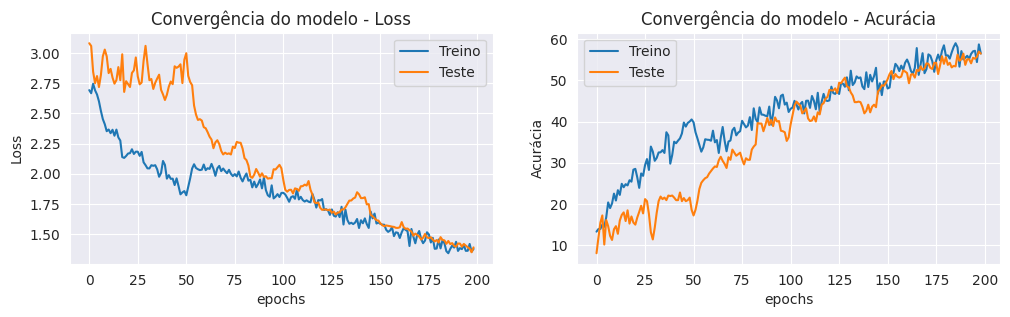

In [40]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,3))

ax1.plot(loss_treino[1:], label = 'Treino')
ax1.plot(loss_test[1:], label = 'Teste')
ax1.set_title('Convergência do modelo - Loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(acc_treino[1:], label = 'Treino')
ax2.plot(acc_test[1:], label = 'Teste')
ax2.set_title('Convergência do modelo - Acurácia')
ax2.set_xlabel('epochs')
ax2.set_ylabel('Acurácia')
ax2.legend()



## Utilizando o modelo

In [41]:
def predict(nome):

  modelo.eval()

  tensor = torch.zeros(len(nome), len(dicionario))

  for i, char in enumerate(nome):

    idx = dicionario.find(char)
    tensor[i, idx] = 1

  tensor = tensor.to(args['device'])

  output = modelo(tensor)

  top_v, top_i = output.data.topk(3, 1, True)

  print(nome)
  for value, index in zip(top_v[0], top_i[0]):

    print(f'{categorias[index]} : {value.item()}')
  print('\n')



## Verificando a inferência do modelo

In [49]:
predict('Bruno')

Bruno
Italian : -0.4587547779083252
Spanish : -2.237569808959961
German : -2.929884910583496




/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [50]:
predict('Giusti')

Giusti
Italian : -0.46037381887435913
Japanese : -2.048968553543091
Scottish : -2.655351161956787




/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [51]:
predict('Loducca')

Loducca
Italian : -0.6122955083847046
Spanish : -1.5596269369125366
Greek : -2.8544750213623047




/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [52]:
predict('Ryuichi')

Ryuichi
Japanese : -0.48275068402290344
Italian : -2.0334975719451904
Polish : -2.8237481117248535




/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
